In [1]:
import json
from joblib import dump, load
from pathlib import Path

import cv2
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.ensemble import RandomForestClassifier

from repath.preprocess.patching import GridPatchFinder, SlidesIndex, CombinedIndex
from repath.preprocess.tissue_detection import TissueDetectorGreyScale, SizedClosingTransform, FillHolesTransform
from repath.preprocess.tissue_detection.blood_mucus import get_slides_annots, apply_tissue_detection, get_features_list, fit_segmenter_multi, predict_segmenter, get_features, pool_blood_mucus, get_annot_areas, calc_confusion_mat_2class, calc_confusion_mat_3class, save_confusion_mat
from repath.utils.convert import get_concat_h, get_concat_v
from repath.utils.paths import project_root
from repath.utils.seeds import set_seed

set_seed(123)
level_label = 5
thumb_level = 7

In [2]:
from repath.data.datasets.bloodmucus import BloodMucus

def test_cervical():
    """ Generated a data-frame of slide_path, annotation_path, label and tags for train dataset.

    Returns:
        DataFrame (pd.DataFrame): Train data frame
    """
    # first set up the paths to the slides without tissue annotations
    root_dir = project_root() / "data" / "icaird_blood"
    image_dir = root_dir   / "images_cervical_temp"
    annot_dir = root_dir / "annotations_cervical_temp"
    
    slide_paths = [p.relative_to(root_dir) for p in image_dir.glob("*.isyntax")]
    annot_paths = [p.relative_to(root_dir) for p in annot_dir.glob("*.txt")]

    slide_paths = sorted(slide_paths)
    annot_paths = sorted(annot_paths)
   
    # turn them into a data frame and pad with empty annotation paths
    df = pd.DataFrame()
    df["slide"] = slide_paths
    df["annotation"] = annot_paths
    df["label"] = ""
    df["tags"] = ""

    return BloodMucus(root_dir, df)

In [6]:
from repath.data.slides.isyntax import Slide

# read in slides and annotations for training
dset = test_cervical()

thumbz = []

for dd in dset:
    slide_path, annot_path, _, _ = dd
    with Slide(dset.root / slide_path) as slide:
        thumb = slide.get_thumbnail(level_label)
        thumbz.append(thumb)


In [12]:
thumbz_out = []

for dd in dset:
    slide_path, annot_path, _, _ = dd
    with Slide(dset.root / slide_path) as slide:
        thumb = slide.get_thumbnail(thumb_level)
        thumbz_out.append(thumb)

In [8]:

# apply tissue detection
morphology_transform1 = SizedClosingTransform(level_in=level_label)
morphology_transform2 = FillHolesTransform(level_in=level_label)
morphology_transforms = [morphology_transform1, morphology_transform2]
tissue_detector = TissueDetectorGreyScale(grey_level=0.85, morph_transform = morphology_transforms)
filtered_thumbz = apply_tissue_detection(thumbz, tissue_detector)

# get features
featz = get_features_list(filtered_thumbz, edges=True)

### classifier specific 
# load classifier
clf = load(project_root() / "experiments" / "bloodmucus_ll_rf" / 'rforest.joblib')

# settings for classifier
patch_level = 0
patch_size = 2**thumb_level
stride = patch_size
scale_factor = 2 ** (level_label - patch_level)
kernel_size = int(patch_size / scale_factor)
label_level_stride = int(stride / scale_factor)


In [22]:
idx = 1
thumb = thumbz[idx]
thumb_out = thumbz_out[idx]
print(thumb.shape, thumb_out.shape)

(2790, 1614, 3) (696, 402, 3)


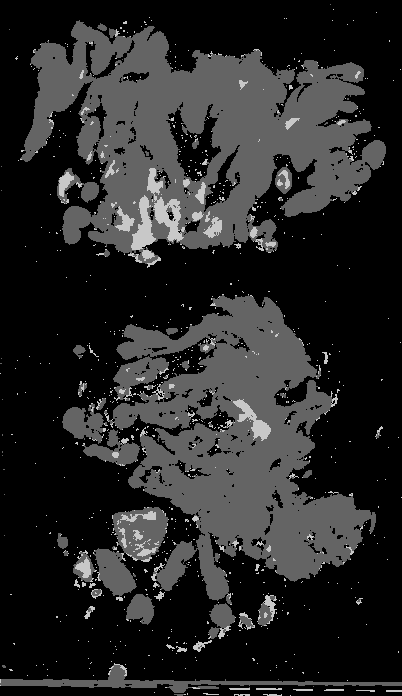

In [23]:
features = get_features(thumb, edges=True)
output = predict_segmenter(features, clf)
tissue_mask = tissue_detector(thumb)
filtered_output = np.where(np.logical_not(tissue_mask), 0, output)
output_labels = pool_blood_mucus(filtered_output, kernel_size, label_level_stride, 0)
if thumb_out.shape[0:2] != output_labels.shape:
    output_labels = output_labels[0:thumb_out.shape[0], 0:thumb_out.shape[1]]
labels_image = Image.fromarray(np.array(output_labels*100, dtype=np.uint8))
labels_image

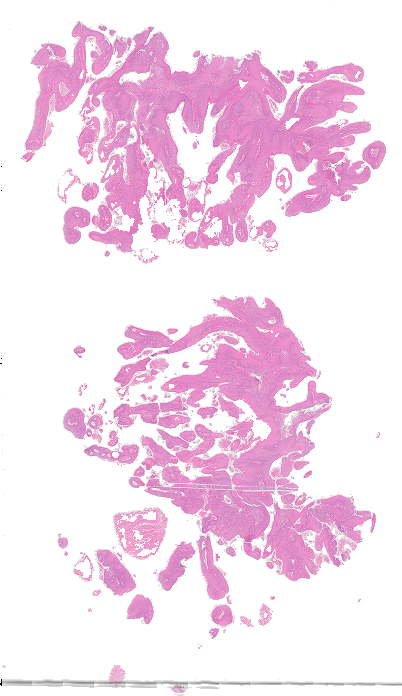

In [24]:
tissue_output = np.where(np.expand_dims(output_labels, axis=-1) == 1, thumb_out, 255)
tissue_image = Image.fromarray(np.array(tissue_output, dtype=np.uint8))
tissue_image

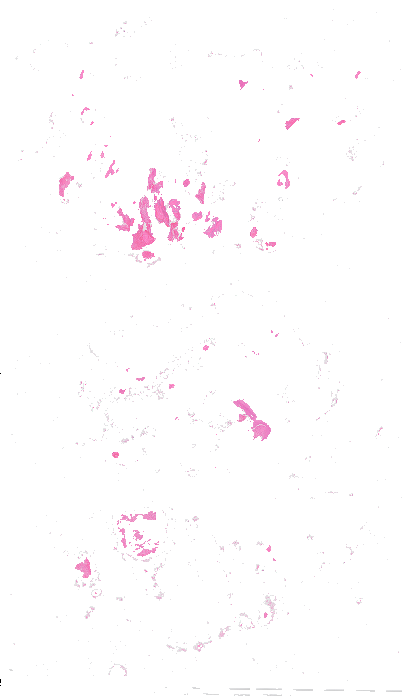

In [29]:
bloodm_output = np.where(np.expand_dims(output_labels, axis=-1) == 2, thumb_out, 255)
bloodm_image = Image.fromarray(np.array(bloodm_output, dtype=np.uint8))
bloodm_image

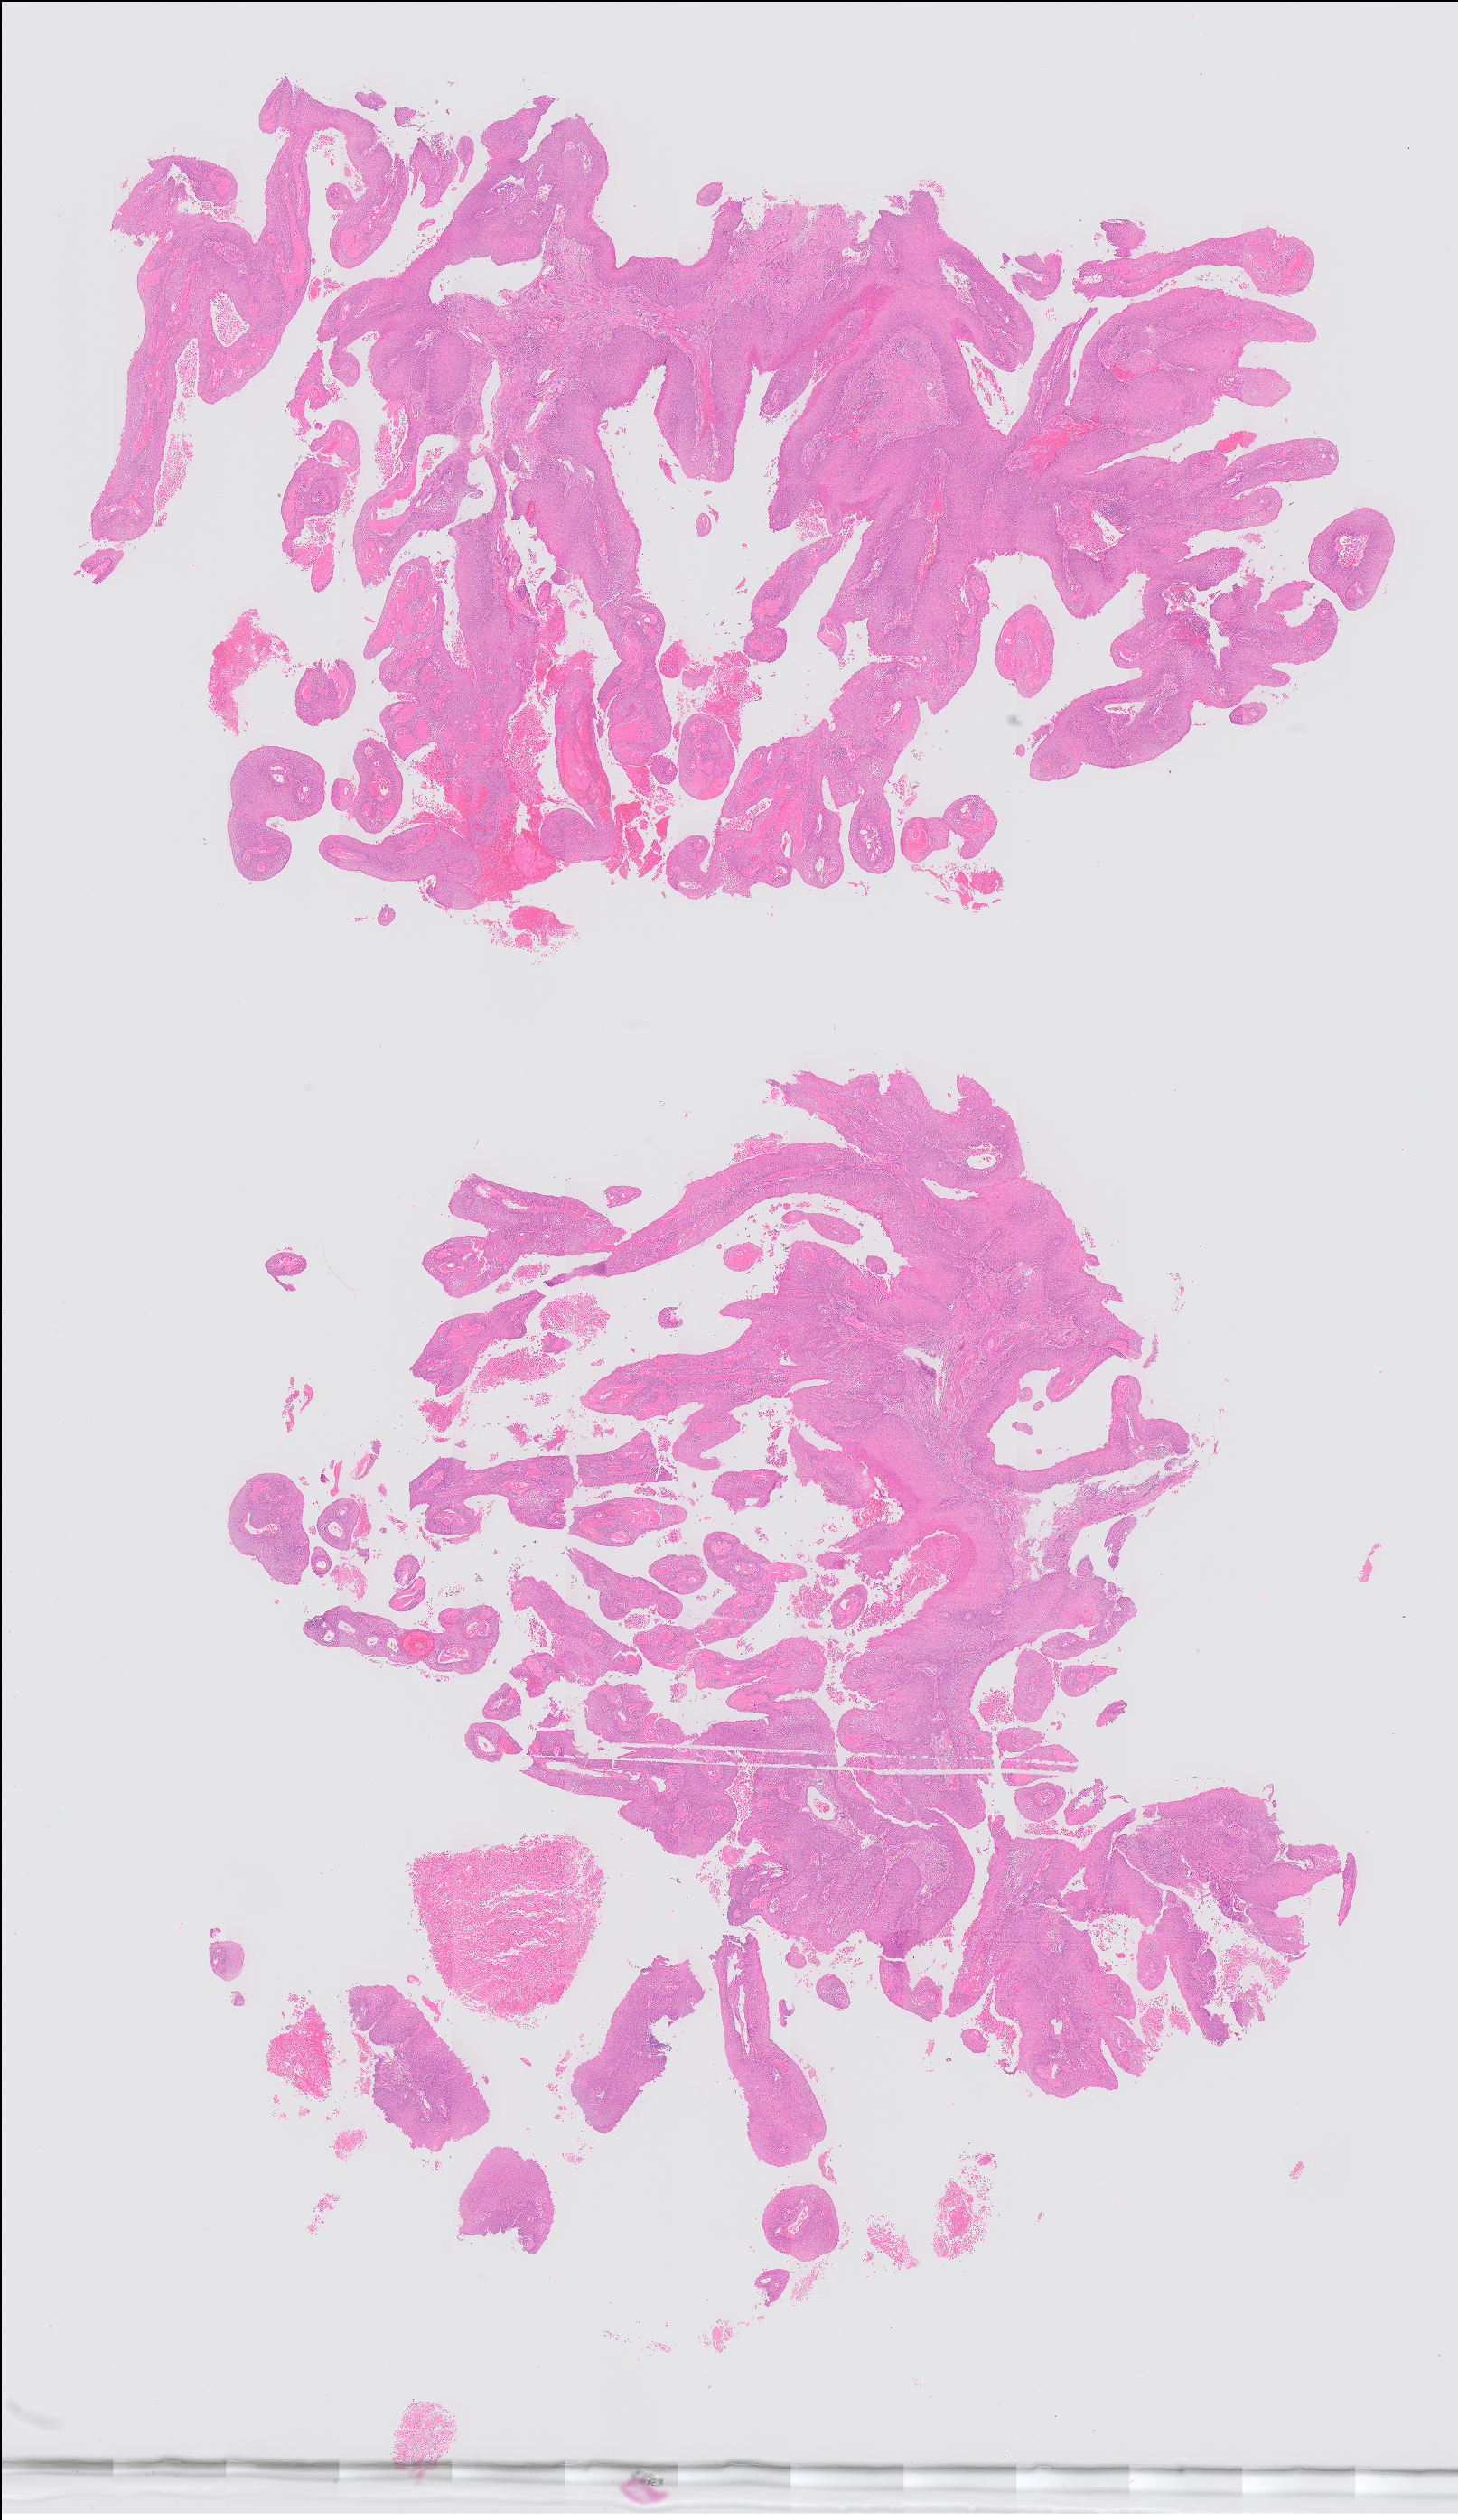

In [28]:
thumb_image = Image.fromarray(np.array(thumb, dtype=np.uint8))
thumb_image